# Определение стоимости автомобилей

## Подготовка данных

In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import catboost
from catboost import cv
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

import catboost
from catboost import cv
from catboost import *
from catboost import datasets

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [56]:
def dropping(cond):
    global df
    outlires = df.query(cond).index 
    df = df.drop(index=outlires)    

In [57]:
df = pd.read_csv('/datasets/autos.csv')

In [58]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [59]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

После первичного осмотра данных мы видим, что в данных присутствуют пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`. Данные столбца `Repaired` можно заполнить значениями no, так как люди скорее всего забывали говорить об этом, так как считали что она только для тех у кого она была в ремонте, также нужно изменить данные с 'no' и 'yes' к '0' и '1'. Остальные данные можно попробовать удалить, так как мы не можем более менее предсказать какое значение в них может быть, и постмотреть сколько данных мы потеряем.  
Данные в столбцах `DateCrawled`, `DateCreated` и `LastSeen` нужно привести к типу datetime, но так как дата скачивания анкеты и последней активности пользователя не влияет на цену автомобиля, то от этих данных можно избавиться
Остальные данные не имеют пропусков и обладают нужным типом. В столбце `RegistrationYear` присутствуют аномальные значения 1000 и 9999, `Power` имеет аномально низкие и высокие значения.  
От столбца `NumberOfPictures` мы можем избавиться так как все значения в нем равны 0
В столбце `Price` присутствуют 0 значения, вряд ли они были сделаны специально, так что от них лучше избавиться

In [61]:
#Просмотр данных на наличие дубликатов связанных с названием
for i in ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']:
    print(df[i].value_counts())
    print('')

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat     

Проблем с названиями обнаружено не было

### Работа с пропусками

In [62]:
df['Repaired'] = df['Repaired'].replace(['yes','no'],[1,0]) #Замена yes, no на 1 и 0 
df['Repaired'] = df['Repaired'].fillna(0) #Заполнение пропущенных значений нулями
df['Repaired'] = df['Repaired'].astype(int)

Попробуем удалить остальные пропуски

In [63]:
#Для удаления делаем копию датафрейма, чтобы посмотреть сколько данных мы потеряем
df_2 = df
df_2 = df_2.dropna()

In [64]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        284126 non-null  object
 1   Price              284126 non-null  int64 
 2   VehicleType        284126 non-null  object
 3   RegistrationYear   284126 non-null  int64 
 4   Gearbox            284126 non-null  object
 5   Power              284126 non-null  int64 
 6   Model              284126 non-null  object
 7   Kilometer          284126 non-null  int64 
 8   RegistrationMonth  284126 non-null  int64 
 9   FuelType           284126 non-null  object
 10  Brand              284126 non-null  object
 11  Repaired           284126 non-null  int64 
 12  DateCreated        284126 non-null  object
 13  NumberOfPictures   284126 non-null  int64 
 14  PostalCode         284126 non-null  int64 
 15  LastSeen           284126 non-null  object
dtypes: int64(8), object(

In [65]:
((354369-284126)/354369)*100 #Подсчет процента пропущенных значений

19.821993458795774

Если мы удалим все пропущенные значения, то потеряем почти 20% данных, что мы не можем допустить, можем попробовать заполнить часть столбцов самыми распространенными значениями (столбцы `Gearbox` и `FuelType` так как там меньше вариантивность и большинство значений принадлежит к одному классу)

In [66]:
df_2 = df
df_2['Gearbox'] = df_2['Gearbox'].fillna('manual') #Заполнение пропусков самым популярным значением
df_2['FuelType'] = df_2['FuelType'].fillna('petrol') 
df_2 = df_2.dropna() 
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304002 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        304002 non-null  object
 1   Price              304002 non-null  int64 
 2   VehicleType        304002 non-null  object
 3   RegistrationYear   304002 non-null  int64 
 4   Gearbox            304002 non-null  object
 5   Power              304002 non-null  int64 
 6   Model              304002 non-null  object
 7   Kilometer          304002 non-null  int64 
 8   RegistrationMonth  304002 non-null  int64 
 9   FuelType           304002 non-null  object
 10  Brand              304002 non-null  object
 11  Repaired           304002 non-null  int64 
 12  DateCreated        304002 non-null  object
 13  NumberOfPictures   304002 non-null  int64 
 14  PostalCode         304002 non-null  int64 
 15  LastSeen           304002 non-null  object
dtypes: int64(8), object(

In [67]:
((354369-304002)/354369)*100

14.213150698847812

После добавления в столбцы `Gearbox` и `FuelType` самых распространенных значений и удаления остальных пропущенных значений в столбцах `Model` и `Vegicletype` мы уменьшили количество теряемых данных до 14%, к сожалению эти пропуски мы не можем заполнить чем либо, так как в данных столбцах большая вариантивность и множество классов имеют близкое к себе количество автомобилей, так что придется работать с данными в таком виде

In [68]:
#Проведение подобной операции с основным датафреймом
df['Gearbox'] = df['Gearbox'].fillna('manual') 
df['FuelType'] = df['FuelType'].fillna('petrol')
df = df.dropna()
df['DateCreated'] = pd.to_datetime(df['DateCreated'],format='%Y-%m-%d %H:%M:%S') #Изменение типа данных в столбце DateCreated
df = df.drop(['NumberOfPictures','DateCrawled','LastSeen'],axis=1) #Удаление столбцов не несущих смысл 

In [69]:
df.drop_duplicates() #Удаление явных дубликатов
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304002 entries, 2 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              304002 non-null  int64         
 1   VehicleType        304002 non-null  object        
 2   RegistrationYear   304002 non-null  int64         
 3   Gearbox            304002 non-null  object        
 4   Power              304002 non-null  int64         
 5   Model              304002 non-null  object        
 6   Kilometer          304002 non-null  int64         
 7   RegistrationMonth  304002 non-null  int64         
 8   FuelType           304002 non-null  object        
 9   Brand              304002 non-null  object        
 10  Repaired           304002 non-null  int64         
 11  DateCreated        304002 non-null  datetime64[ns]
 12  PostalCode         304002 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(5)
me

Дубликатов обнаружено не было

### Проверка данных на аномалии

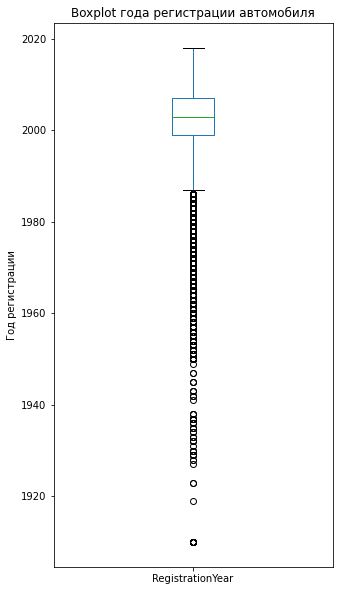

In [70]:
plt.figure(figsize=(5,10))
plt.title('Boxplot года регистрации автомобиля')
plt.ylabel("Год регистрации")
df['RegistrationYear'].plot(kind='box');

По графику мы видим, что несмотря на наличие некоторых аномальных значений все они не противоречат логике и мы можем их оставить, так как могут продавать и очень старые автомобили

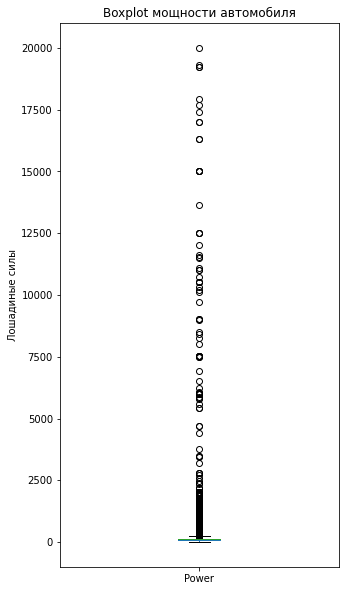

In [71]:
plt.figure(figsize=(5,10))
plt.title('Boxplot мощности автомобиля')
plt.ylabel("Лошадиные силы")
df['Power'].plot(kind='box');

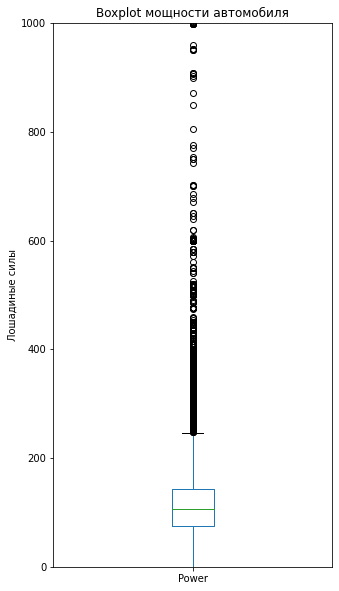

In [72]:
plt.figure(figsize=(5,10))
plt.title('Boxplot мощности автомобиля')
plt.ylabel("Лошадиные силы")
plt.axis(ymax=1000)
df['Power'].plot(kind='box');

По графикам мощности видно, что в данных есть аномально высокие значения мощности, так как самая высокая мощность на данный момент 1600 л.с., то все значения выше этого можно убирать как заведомо ложные. Также так как данные у нас были выгружены не позднее 2016 года, то и год регистрации более 2016 года не может присутствовать. 

In [73]:
dropping('Power>1600')
dropping('RegistrationYear>2016')
dropping('Price<1')

In [74]:
outlires = df.query('Power>1600').index 
df = df.drop(index=outlires)
outlires = df.query('RegistrationYear>2016').index 
df = df.drop(index=outlires)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297767 entries, 2 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              297767 non-null  int64         
 1   VehicleType        297767 non-null  object        
 2   RegistrationYear   297767 non-null  int64         
 3   Gearbox            297767 non-null  object        
 4   Power              297767 non-null  int64         
 5   Model              297767 non-null  object        
 6   Kilometer          297767 non-null  int64         
 7   RegistrationMonth  297767 non-null  int64         
 8   FuelType           297767 non-null  object        
 9   Brand              297767 non-null  object        
 10  Repaired           297767 non-null  int64         
 11  DateCreated        297767 non-null  datetime64[ns]
 12  PostalCode         297767 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(5)
me

In [76]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,Repaired,PostalCode
count,297767.000000,297767.000000,297767.000000,297767.000000,297767.000000,297767.000000,297767.000000
mean,4808.065534,2002.487609,112.865264,128382.325778,6.009722,0.097331,51057.232007
std,4589.265708,6.288980,64.620772,36752.889391,3.587504,0.296409,25737.723203
min,1.000000,1910.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.000000,30851.000000
50%,3100.000000,2003.000000,107.000000,150000.000000,6.000000,0.000000,50127.000000
75%,6950.000000,2007.000000,144.000000,150000.000000,9.000000,0.000000,71665.000000
max,20000.000000,2016.000000,1600.000000,150000.000000,12.000000,1.000000,99998.000000


## Обучение моделей

### Подготовка данных к обучению

In [77]:
df_2 = df

In [78]:
df_ohe = pd.get_dummies(df, drop_first=True) #Прямое кодирование для модели линейной регрессии

In [79]:
encoder = OrdinalEncoder() #Порядковое кодирование для моделей RandomForest и DecisionTree
df_oe = df
df_oe[['VehicleType','Gearbox','Model','FuelType','Brand']] = encoder.fit_transform(df[['VehicleType','Gearbox','Model','FuelType','Brand']])

In [80]:
features_ohe = df_ohe.drop(['Price'],axis=1) #Выделение датафрейма с признаками для модели линейной регрессии
target_ohe = df_ohe['Price']

features_oe = df_oe.drop(['Price'],axis=1) #Выделение датафрейма с признаками 
target_oe = df_oe['Price']

In [81]:
#Разделение данных на тренировочную и тестовую выборки в соотношении 80% к 20%
features_train_ohe,features_test_ohe,target_train_ohe,target_test_ohe = train_test_split(features_ohe,target_ohe,test_size=0.2,
                                                                        random_state=12345, shuffle=True)

features_train_oe,features_test_oe,target_train_oe,target_test_oe = train_test_split(features_oe,target_oe,test_size=0.2,
                                                                        random_state=12345, shuffle=True)

In [82]:
numeric=['RegistrationYear', 'Power',
       'Kilometer', 'RegistrationMonth', 'Repaired',
        'PostalCode']

scaler = StandardScaler() #Масштабирование данных
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

    

In [29]:
%%time
#Обучение модели линейной регрессии
model_lin = LinearRegression()
f_t_o = features_train_ohe.drop('DateCreated',axis=1)

scores = cross_val_score(model_lin,f_t_o,target_train_ohe,cv=5,scoring='neg_root_mean_squared_error')
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -2625.9124448075304
CPU times: user 57.8 s, sys: 20.5 s, total: 1min 18s
Wall time: 1min 18s


In [30]:
%%time

model_lin.fit(f_t_o,target_train_ohe)

CPU times: user 14.5 s, sys: 4.71 s, total: 19.2 s
Wall time: 19.2 s


LinearRegression()

Значение метрики RMSE модели линейной регрессии оказалось равно 2625.912 евро, при этом обучение модели заняло 40 с

In [31]:
#Обучение модели решающего дерева
tree_model = DecisionTreeClassifier(random_state=12345,class_weight='balanced')
tree_params = {'max_depth': range(12,13)}
tree_grid = GridSearchCV(tree_model, tree_params, cv=6,n_jobs=-1,verbose=True,scoring='neg_root_mean_squared_error')
tree_grid.fit(features_train_oe.drop('DateCreated',axis=1),target_train_oe)
print('Лучшая модель дерева показала результат:',tree_grid.best_score_,' при глубине дерева =', tree_grid.best_params_)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(("The least populated class in y has only %d"


Лучшая модель дерева показала результат: -4925.469567188751  при глубине дерева = {'max_depth': 12}


In [32]:
%%time
tree_model = DecisionTreeClassifier(random_state=12345,class_weight='balanced',max_depth=12)
tree_model.fit(features_train_oe.drop('DateCreated',axis=1),target_train_oe)

CPU times: user 2.48 s, sys: 53.6 ms, total: 2.53 s
Wall time: 2.54 s


DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                       random_state=12345)

По итогу обучения модели случайного дерева, модель показала худший результат

In [33]:
%%time
#Обучение модели LightGBM
model_lgm = LGBMRegressor(random_state=12345)
lgm_params = {'n_estimators':range(1,20)}
lgm_grid = GridSearchCV(model_lgm, lgm_params, cv=3,n_jobs=-1,verbose=True,scoring='neg_root_mean_squared_error')
lgm_grid.fit(features_train_oe.drop('DateCreated',axis=1),target_train_oe)
print('Лучшая модель леса показала результат:',lgm_grid.best_score_,' при параметрах =', lgm_grid.best_params_)


Fitting 3 folds for each of 19 candidates, totalling 57 fits
Лучшая модель леса показала результат: -2111.9504547569127  при параметрах = {'n_estimators': 19}
CPU times: user 52.7 s, sys: 0 ns, total: 52.7 s
Wall time: 53.1 s


In [34]:
%%time
model_lgm = LGBMRegressor(n_estimators=19, num_leaves = 2**11, learning_rate = 1, random_state=12345)
model_lgm.fit(features_train_oe.drop('DateCreated',axis=1),target_train_oe)

CPU times: user 17.3 s, sys: 0 ns, total: 17.3 s
Wall time: 17.3 s


LGBMRegressor(learning_rate=1, n_estimators=19, num_leaves=2048,
              random_state=12345)

Модель LightGBM показала результаты лучше чем у линейной регрессии

In [94]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999999999999

<IPython.core.display.Javascript object>

In [ ]:
%%time
#Создание и обучение модели CatBoost без категорильных признаков
features_tr2,features_valid_2,target_tr2,target_valid_2 = train_test_split(features_train_oe,target_train_oe,test_size=0.2,
                                                                        random_state=12345, shuffle=True)

model = CatBoostRegressor(
    loss_function = 'RMSE',
    iterations = 10000,
    random_seed = 12345,
    learning_rate = 1,
    early_stopping_rounds = 3000
)

model.fit(
    features_tr2, target_tr2,
    eval_set=(features_valid_2, target_valid_2),
    verbose=False,
    plot=True
)

## Анализ моделей

Для удобства воспринятия информации по данным обучения и предсказаний будет создана таблица, в дополнении к этому каждой модели будут присвоены номера от 1 до n, где n количество моделей, показывающие качество модели в значении RMSE и скорости обучения (сек). Затем выбор лучшей модели будет осуществлен по формуле:
$$
A = (X+Y)
$$
где Х- позиция по значению RMSE, Y-позиция по значению скорости обучения.  
И модель с минимальным значением А будет наилучшим вариантом

In [36]:
df_c = pd.DataFrame()
df_c = df_c.reindex(['LinearRegression','DecisionTree','LightGBM','CatBoost'])
df_c['RMSE']=[2625.912,4925.470,2111.950,1552.256]
df_c['RMSE_place'] = [3,4,2,1]
df_c['time_learning'] = [40,5,20,23]
df_c['time_learning_place'] = [4,1,2,3]
df_c['concl'] = df_c['RMSE_place']+df_c['time_learning_place']


In [37]:
df_c

,RMSE,RMSE_place,time_learning,time_learning_place,concl
LinearRegression,2625.912,3,40,4,7
DecisionTree,4925.470,4,5,1,5
LightGBM,2111.950,2,20,2,4
CatBoost,1552.256,1,23,3,4


По итогу мы видим, что самыми лучшими моделями оказались: CatBoost и LightGBM, LightGBM оказалась лучше всех в скорости обучения, но разница с CatBoost составляет лишь 3 сек, в то время как Catboost показал более лучшие результаты RMSE, что приводит к выводу, что использовать лучше всего именно его

# Тестирование лучшей модели

In [38]:
predictions = model.predict(features_test_oe)
print('Итоговые результат RMSE лучшей модели (CatBoost) составил:',mean_squared_error(predictions,target_test_oe,squared=False))

Итоговые результат RMSE лучшей модели (CatBoost) составил: 1558.914375937537
